<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [1]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [2]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [3]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [4]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



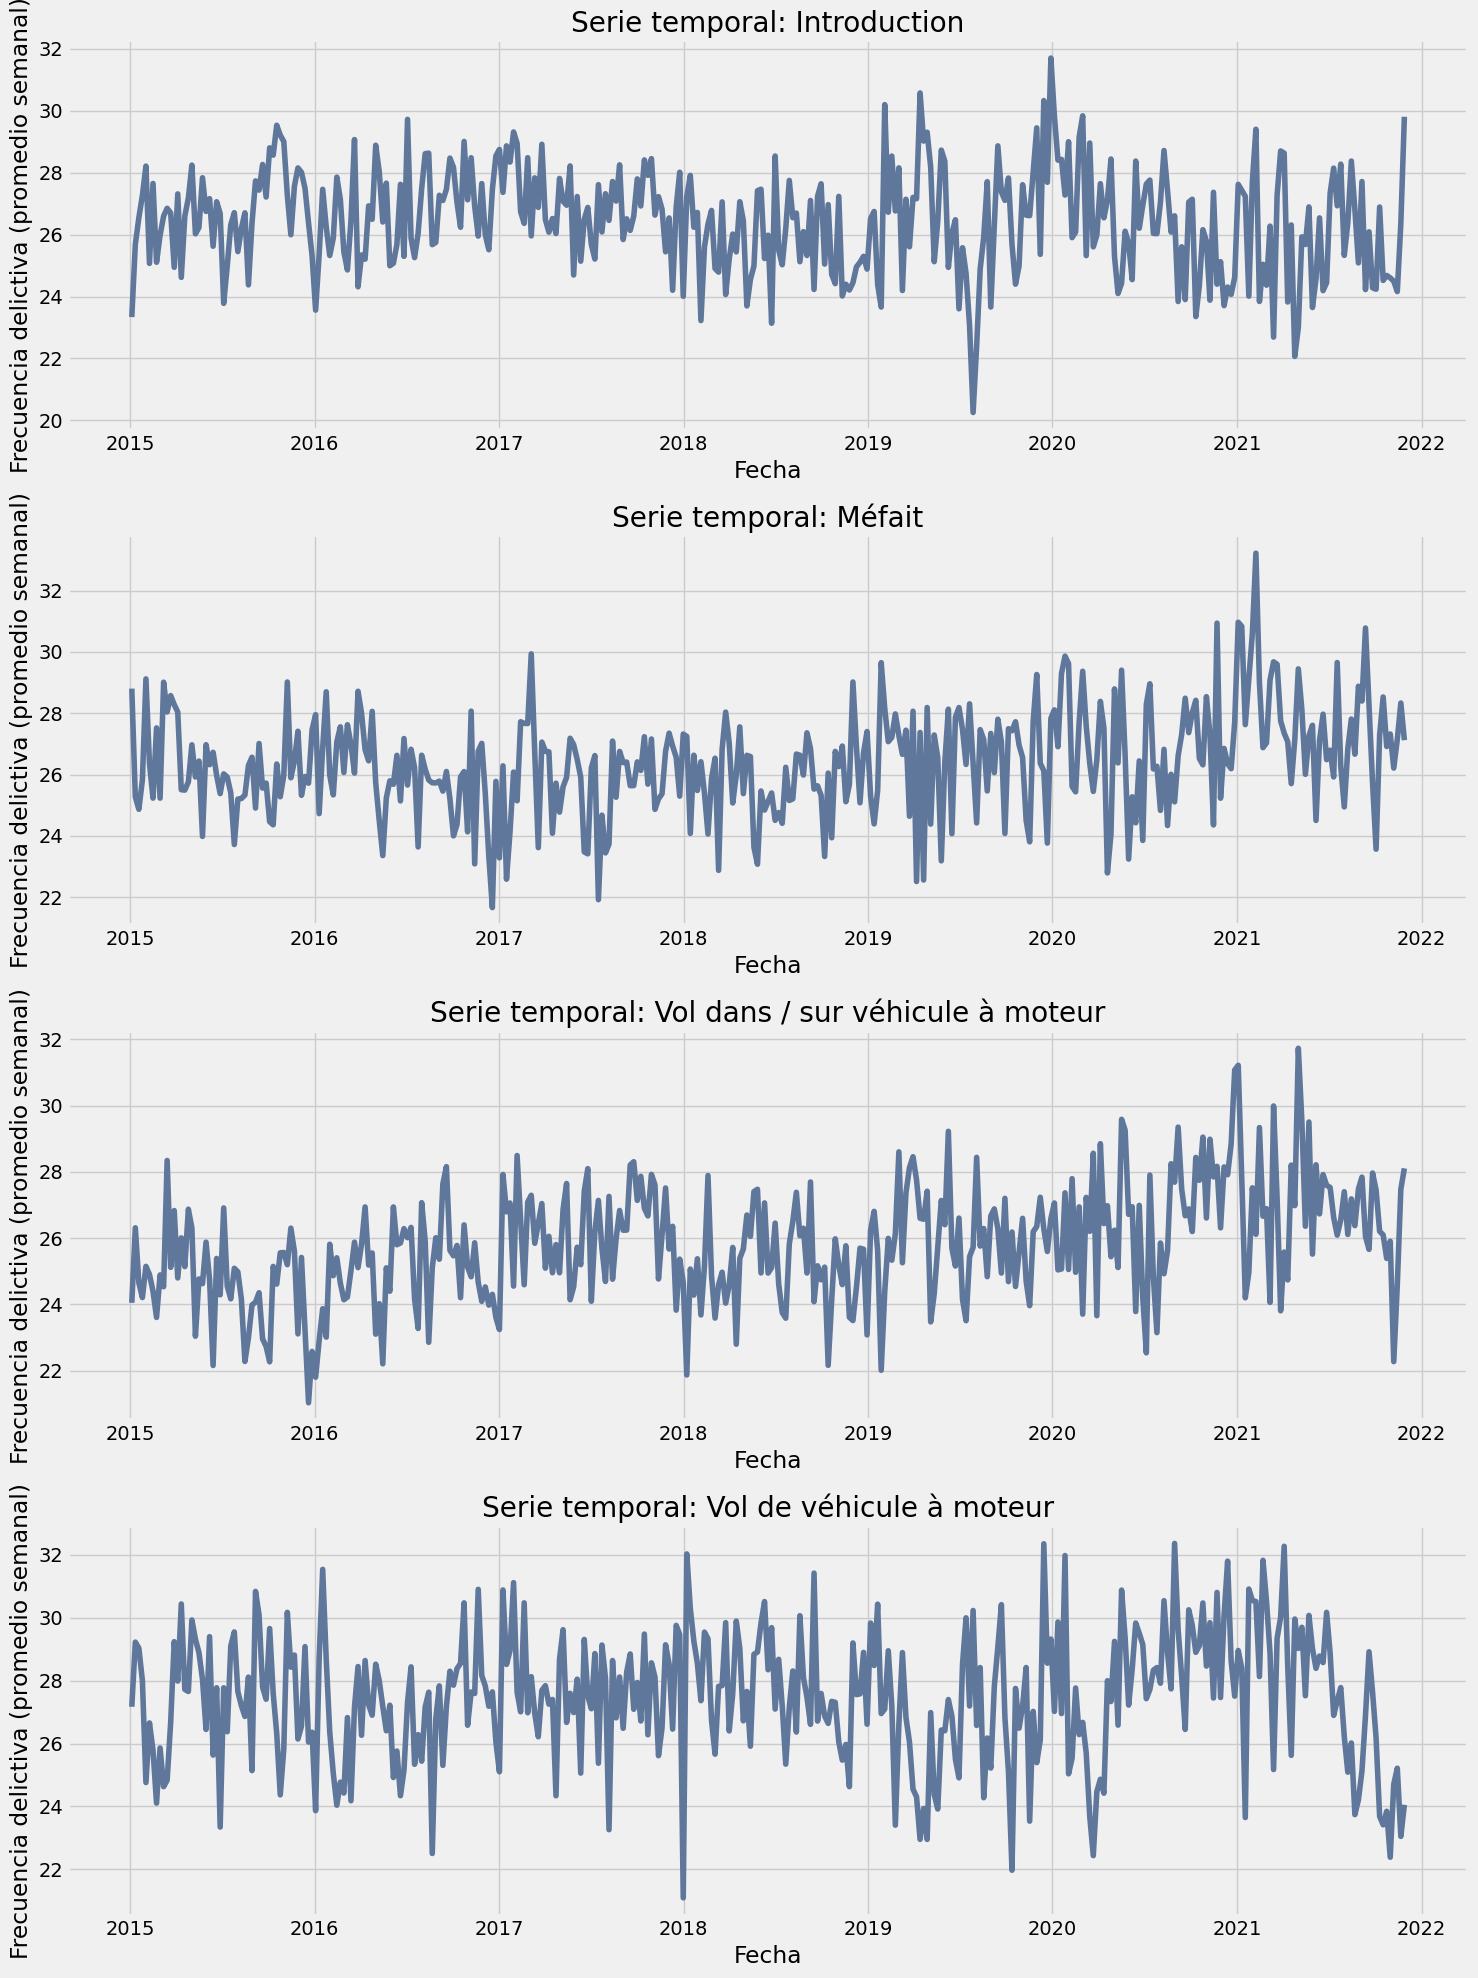

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 20))

# Plot y_s1
sns.lineplot(data=y_s1, x=y_s1.index, y='pdq', ax=axes[0])
axes[0].set_title(f'Serie temporal: {validate_categorie[0]}')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Frecuencia delictiva (promedio semanal)')

# Plot y_s2
sns.lineplot(data=y_s2, x=y_s2.index, y='pdq', ax=axes[1])
axes[1].set_title(f'Serie temporal: {validate_categorie[1]}')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Frecuencia delictiva (promedio semanal)')

# Plot y_s3
sns.lineplot(data=y_s3, x=y_s3.index, y='pdq', ax=axes[2])
axes[2].set_title(f'Serie temporal: {validate_categorie[2]}')
axes[2].set_xlabel('Fecha')
axes[2].set_ylabel('Frecuencia delictiva (promedio semanal)')

# Plot y_s4
sns.lineplot(data=y_s4, x=y_s4.index, y='pdq', ax=axes[3])
axes[3].set_title(f'Serie temporal: {validate_categorie[3]}')
axes[3].set_xlabel('Fecha')
axes[3].set_ylabel('Frecuencia delictiva (promedio semanal)')

plt.tight_layout()
plt.show()



1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



### Análisis exploratorio para la serie temporal: Introduction



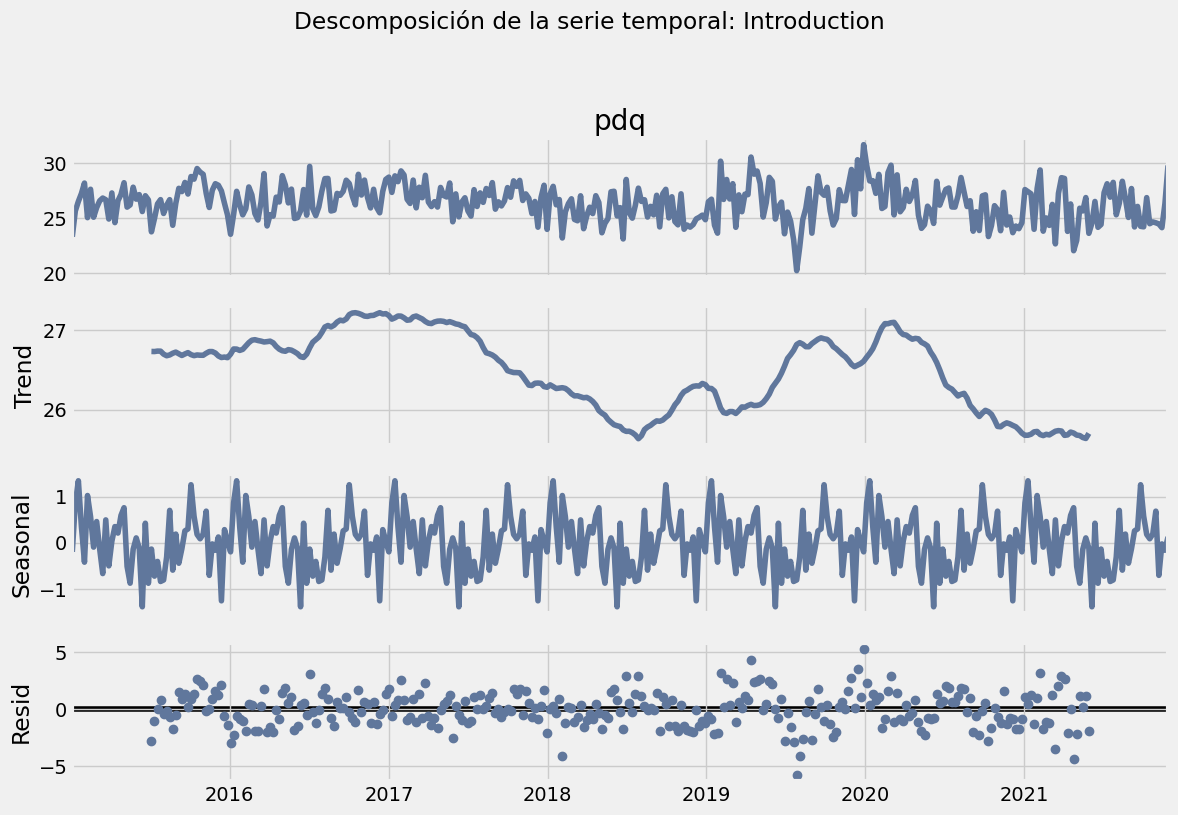

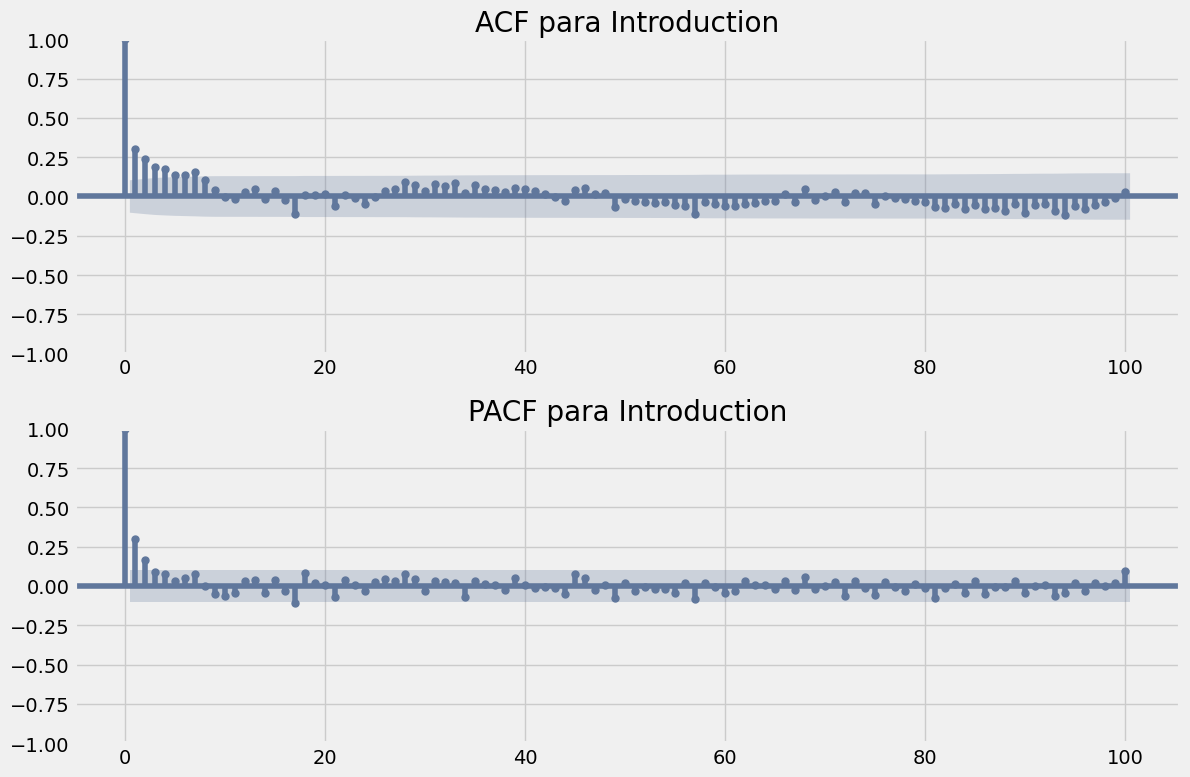


--- Descripción de la serie seleccionada ---
count    361.000000
mean      26.437394
std        1.658831
min       20.255319
25%       25.227586
50%       26.515873
75%       27.611940
max       31.702479
Name: pdq, dtype: float64


In [6]:
selected_series_name = validate_categorie[0]
y_selected = y_s1.copy()

print(f"### Análisis exploratorio para la serie temporal: {selected_series_name}\n")

# Descomposición de la serie temporal
# Dado que el remuestreo es semanal, la estacionalidad podría ser anual (52 semanas)
# o semanal (although the data is already weekly).
# Let's assume a yearly seasonality for weekly data, so S=52.
decomposition = sm.tsa.seasonal_decompose(y_selected['pdq'].dropna(), model='additive', period=52) # Period for yearly seasonality in weekly data

fig = decomposition.plot()
fig.set_size_inches(12, 8)
fig.suptitle(f'Descomposición de la serie temporal: {selected_series_name}', y=1.02) # Ajustar el título
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Ajustar el diseño para evitar superposición con el título
plt.show()

# Gráficos de Autocorrelación (ACF) y Autocorrelación Parcial (PACF)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
sm.graphics.tsa.plot_acf(y_selected['pdq'].dropna(), lags=100, ax=axes[0], title=f'ACF para {selected_series_name}')
sm.graphics.tsa.plot_pacf(y_selected['pdq'].dropna(), lags=100, ax=axes[1], title=f'PACF para {selected_series_name}')
plt.tight_layout()
plt.show()

print("\n--- Descripción de la serie seleccionada ---")
print(y_selected['pdq'].describe())


In [7]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Métricas del mejor modelo SARIMA ###
mae                         1.5876
mse                         3.4224
rmse                          1.85
mape                        0.0622
maape                        0.062
wmape                       0.0614
mmape                       0.0599
smape                       0.0614
model    SARIMA_(0,0,0)X(1,0,1,12)
Name: 5, dtype: object

Mejor orden SARIMA: (0, 0, 0)
Mejor orden estacional: (1, 0, 1, 12)

### Resumen del mejor modelo SARIMA ###
                                 SARIMAX Results                                  
Dep. Variable:                        pdq   No. Observations:                  313
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood                -588.164
Date:                    Mon, 10 Nov 2025   AIC                           1182.328
Time:                            04:06:06   BIC                           1193.440
Sample:                        01-04-2015   HQIC                          1186.775
             

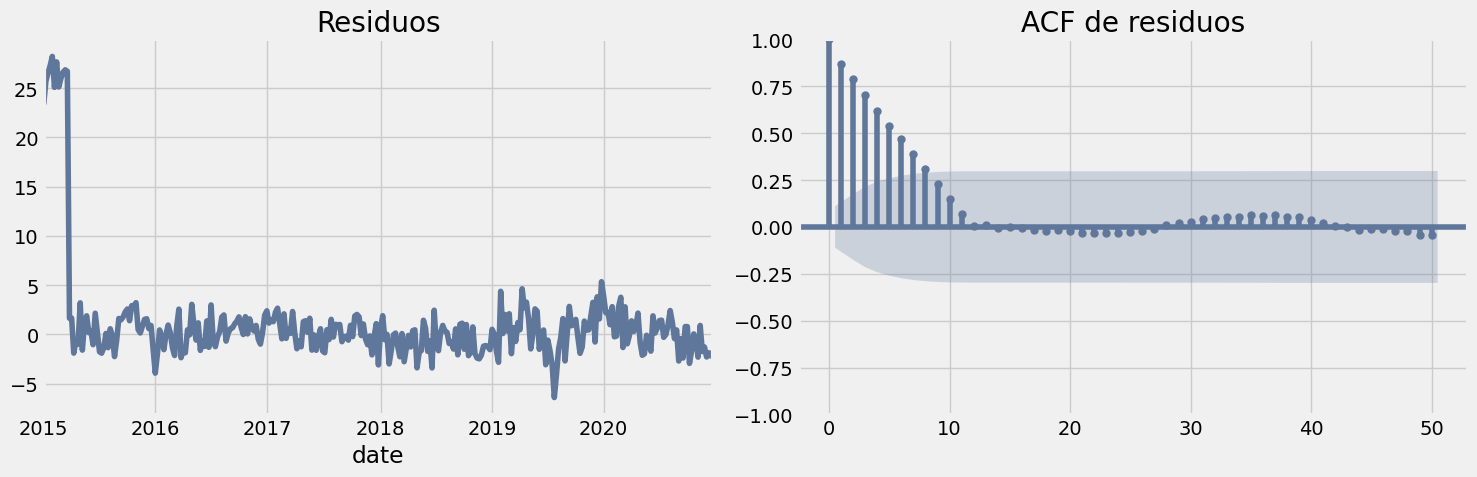

Prueba de Ljung-Box para ruido blanco:
       lb_stat      lb_pvalue
10  980.960115  2.360699e-204
20  983.140733  1.535391e-195


In [8]:
all_metrics = []

for param_order, param_seasonal_order in params:
    try:
        model_instance = SarimaModels(params=[param_order, param_seasonal_order])
        metrics = model_instance.metrics(y_selected, target_date)
        all_metrics.append(metrics)
    except Exception as e:
        # Opcionalmente imprimir el error para depurar conjuntos específicos de parámetros
        # print(f"Error con SARIMA{param_order}x{param_seasonal_order} : {e}")
        continue

# Concatenar todas las métricas en un único DataFrame
if all_metrics:
    results_df = pd.concat(all_metrics, ignore_index=True)
    # Seleccionar el mejor modelo en base a MAE (u otra métrica deseada)
    best_model_metrics = results_df.loc[results_df['mae'].idxmin()]
    print("### Métricas del mejor modelo SARIMA ###")
    print(best_model_metrics)

    # Extraer los parámetros del mejor modelo
    best_model_name = best_model_metrics['model']
    best_order_str = best_model_name.split('_')[1].split('X')[0]
    best_seasonal_order_str = best_model_name.split('_')[1].split('X')[1]

    # Convertir las tuplas en formato de cadena de vuelta a tuplas reales para SARIMAX
    best_order = tuple(map(int, best_order_str[1:-1].split(',')))
    best_seasonal_order = tuple(map(int, best_seasonal_order_str[1:-1].split(',')))

    print(f"\nMejor orden SARIMA: {best_order}")
    print(f"Mejor orden estacional: {best_seasonal_order}")

    # Ajustar el mejor modelo en los datos de entrenamiento
    y_train, y_test = SarimaModels([best_order, best_seasonal_order]).test_train_model(y_selected, target_date)
    best_model = SARIMAX(y_train,
                         order=best_order,
                         seasonal_order=best_seasonal_order,
                         enforce_stationarity=False,
                         enforce_invertibility=False)
    best_model_fit = best_model.fit(disp=0)

    print("\n### Resumen del mejor modelo SARIMA ###")
    print(best_model_fit.summary())

    # Evaluar los residuos para ruido blanco
    print("\n### Análisis de residuos ###")
    residuals = best_model_fit.resid
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    residuals.plot(ax=ax[0], title="Residuos")
    sm.graphics.tsa.plot_acf(residuals, lags=50, ax=ax[1], title="ACF de residuos")
    plt.tight_layout()
    plt.show()

    # Prueba de Ljung-Box para ruido blanco
    ljung_box = sm.stats.acorr_ljungbox(residuals, lags=[10, 20], return_df=True)
    print("Prueba de Ljung-Box para ruido blanco:")
    print(ljung_box)

else:
    print("No se pudo ajustar ningún modelo con éxito.")


In [9]:
print("### Interpretación de la Validación de Residuos ###")
print("Basándonos en el análisis de los residuos del mejor modelo SARIMA, podemos observar lo siguiente:")
print("\n1. **Gráfico de Residuos:** El gráfico de residuos muestra fluctuaciones que no parecen ser completamente aleatorias y estacionarias alrededor de cero. Esto sugiere la presencia de patrones no capturados por el modelo.")
print("\n2. **ACF de Residuos:** La Función de Autocorrelación (ACF) de los residuos muestra correlaciones significativas en varios lags (barras que exceden las bandas de confianza). Esto indica que los residuos no son independientes y presentan estructura de autocorrelación.")
print("\n3. **Prueba de Ljung-Box:**")
print(f"   - Los p-valores de la prueba de Ljung-Box para los lags 10 y 20 son {ljung_box.loc[10, 'lb_pvalue']:.2e} y {ljung_box.loc[20, 'lb_pvalue']:.2e} respectivamente.")
print("   - Dado que ambos p-valores son mucho menores que un nivel de significancia común (e.g., 0.05), **rechazamos la hipótesis nula** de que los residuos son ruido blanco.")
print("\n**Conclusión:** Los residuos del modelo SARIMA óptimo (0,0,0)x(1,0,1,12) no se comportan como ruido blanco. Esto implica que el modelo no ha capturado completamente toda la información relevante de la serie temporal y que existe autocorrelación residual que podría ser explotada para mejorar el modelo.")

### Interpretación de la Validación de Residuos ###
Basándonos en el análisis de los residuos del mejor modelo SARIMA, podemos observar lo siguiente:

1. **Gráfico de Residuos:** El gráfico de residuos muestra fluctuaciones que no parecen ser completamente aleatorias y estacionarias alrededor de cero. Esto sugiere la presencia de patrones no capturados por el modelo.

2. **ACF de Residuos:** La Función de Autocorrelación (ACF) de los residuos muestra correlaciones significativas en varios lags (barras que exceden las bandas de confianza). Esto indica que los residuos no son independientes y presentan estructura de autocorrelación.

3. **Prueba de Ljung-Box:**
   - Los p-valores de la prueba de Ljung-Box para los lags 10 y 20 son 2.36e-204 y 1.54e-195 respectivamente.
   - Dado que ambos p-valores son mucho menores que un nivel de significancia común (e.g., 0.05), **rechazamos la hipótesis nula** de que los residuos son ruido blanco.

**Conclusión:** Los residuos del modelo SARIMA óptim




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [10]:
!pip install --upgrade prophet cmdstanpy
print("Prophet y CmdStanPy actualizados. Por favor, reinicia el entorno de ejecución (Runtime -> Restart runtime) y luego ejecuta la celda anterior nuevamente.")

Prophet y CmdStanPy actualizados. Por favor, reinicia el entorno de ejecución (Runtime -> Restart runtime) y luego ejecuta la celda anterior nuevamente.


In [11]:
from prophet import Prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Predicciones de Prophet ###
            ds       yhat  yhat_lower  yhat_upper
313 2021-01-03  26.398857   24.298084   28.271974
314 2021-01-10  26.511777   24.482372   28.513682
315 2021-01-17  26.521908   24.526002   28.411794
316 2021-01-24  26.533121   24.742214   28.433455
317 2021-01-31  26.588592   24.523732   28.509043


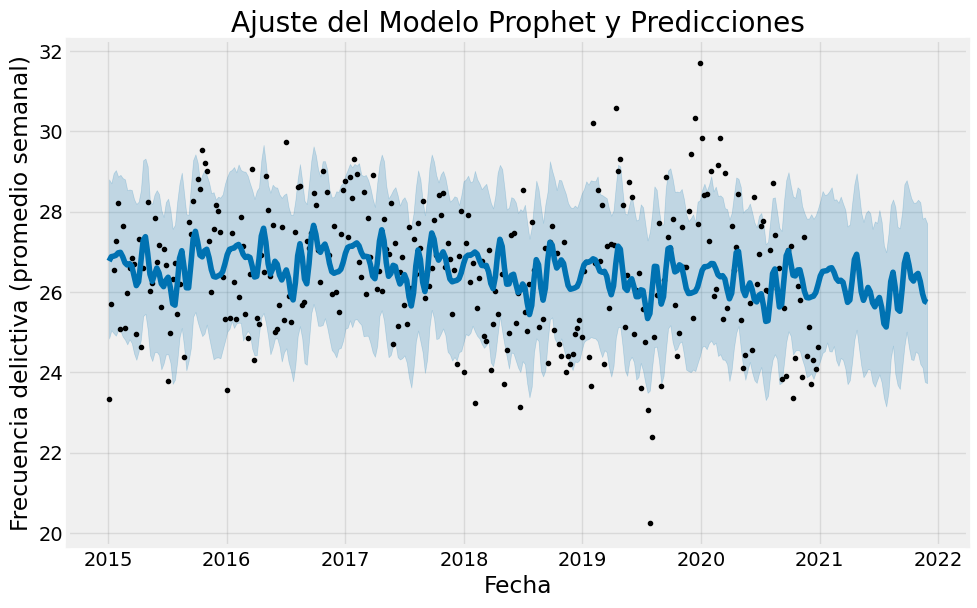

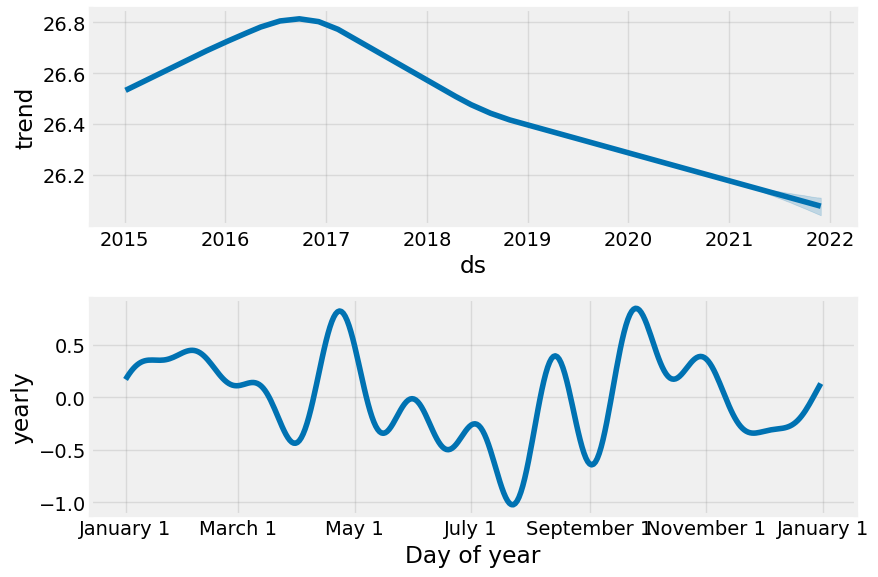

In [12]:
import pandas as pd
from prophet import Prophet

# Preparar los datos para Prophet
# Prophet requiere las columnas 'ds' (datetime) y 'y' (valor)
df_prophet = y_selected.reset_index()
df_prophet = df_prophet.rename(columns={'date': 'ds', 'pdq': 'y'})

# Dividir los datos en entrenamiento y prueba usando el mismo target_date
y_train_prophet = df_prophet[df_prophet['ds'] < target_date]
y_test_prophet = df_prophet[df_prophet['ds'] >= target_date]

# Inicializar y ajustar el modelo Prophet
m = Prophet()
m.fit(y_train_prophet)

# Crear un DataFrame con las fechas futuras para realizar las predicciones
future = m.make_future_dataframe(periods=len(y_test_prophet), freq='W')

# Realizar las predicciones
forecast = m.predict(future)

# Filtrar las predicciones para el período de prueba
forecast_test = forecast[forecast['ds'] >= target_date]

# Mostrar las primeras filas de las predicciones
print("### Predicciones de Prophet ###")
print(forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# Opcional: Visualizar el ajuste y las predicciones
fig = m.plot(forecast)
plt.title('Ajuste del Modelo Prophet y Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia delictiva (promedio semanal)')
plt.show()

fig2 = m.plot_components(forecast)
plt.show()

In [13]:
# Preparar DataFrame para calcular métricas de Prophet
# Asegurarse de que las fechas estén alineadas

# Asegurarse de que 'ds' en forecast_test y 'ds' en y_test_prophet sean el mismo tipo y estén ordenados
forecast_test_aligned = forecast_test.set_index('ds')['yhat']
y_test_prophet_aligned = y_test_prophet.set_index('ds')['y']

# Crear un DataFrame para las métricas de Prophet
df_prophet_metrics_input = pd.DataFrame({
    'y': y_test_prophet_aligned,
    'yhat': forecast_test_aligned
}).dropna()

# Calcular métricas para Prophet
prophet_metrics = summary_metrics(df_prophet_metrics_input)
prophet_metrics['model'] = 'Prophet'

# Convertir best_model_metrics (SARIMA) a DataFrame para concatenar
sarima_metrics_df = pd.DataFrame([best_model_metrics]).drop(columns=['model'])
sarima_metrics_df['model'] = best_model_metrics['model']

# Concatenar los DataFrames de métricas
comparison_df = pd.concat([sarima_metrics_df, prophet_metrics], ignore_index=True)

print("### Comparación de Métricas de Rendimiento (SARIMA vs Prophet) ###")
print(comparison_df.set_index('model'))

### Comparación de Métricas de Rendimiento (SARIMA vs Prophet) ###
                              mae     mse    rmse    mape   maape   wmape  \
model                                                                       
SARIMA_(0,0,0)X(1,0,1,12)  1.5876  3.4224  1.8500  0.0622  0.0620  0.0614   
Prophet                    1.7079  4.1305  2.0324  0.0670  0.0667  0.0660   

                            mmape   smape  
model                                      
SARIMA_(0,0,0)X(1,0,1,12)  0.0599  0.0614  
Prophet                    0.0645  0.0660  


### Análisis Comparativo (SARIMA vs Prophet)

Basándonos en las métricas de rendimiento obtenidas, podemos realizar el siguiente análisis comparativo entre el modelo SARIMA y Prophet:

*   **Métricas de Error:**
    *   **MAE (Error Absoluto Medio):** El modelo SARIMA obtuvo un MAE de **1.5876**, mientras que Prophet tuvo un MAE de **1.7079**. Un MAE menor indica una mejor precisión, por lo que SARIMA parece tener un rendimiento ligeramente superior en este aspecto.
    *   **MSE (Error Cuadrático Medio) y RMSE (Raíz del Error Cuadrático Medio):** De manera similar, SARIMA presenta valores de MSE (**3.4224**) y RMSE (**1.8500**) más bajos que Prophet (MSE: **4.1305**, RMSE: **2.0324**). Esto sugiere que SARIMA no solo tiene errores promedio más pequeños, sino que también maneja mejor los errores grandes, ya que el RMSE penaliza más los errores mayores.
    *   **MAPE, MAAPE, WMAPE, MMAPE, SMAPE:** En todas las métricas de error porcentual, SARIMA consistentemente muestra valores ligeramente inferiores a Prophet. Por ejemplo, el MAPE de SARIMA es **0.0622** frente a **0.0670** de Prophet. Esto refuerza la idea de que SARIMA es marginalmente más preciso en la predicción para esta serie temporal específica y configuración.

*   **Supuestos y Enfoque:**
    *   **SARIMA (Statistical AutoRegressive Integrated Moving Average):** Es un modelo estadístico que se basa en la identificación de patrones de autocorrelación y estacionalidad en los datos. Requiere que la serie sea estacionaria (o que se haga estacionaria mediante diferenciación) y asume una estructura lineal. Su ajuste es más laborioso, ya que implica la selección de varios hiperparámetros (p, d, q) para el componente no estacional y (P, D, Q, S) para el estacional, a menudo con la ayuda de funciones de autocorrelación (ACF y PACF) y criterios de información (AIC/BIC).
    *   **Prophet:** Desarrollado por Facebook, es un modelo que descompone la serie temporal en componentes de tendencia, estacionalidad (diaria, semanal, anual) y festividades. Su enfoque es más modular y robusto frente a datos faltantes o valores atípicos. Es más fácil de usar, ya que la mayoría de los hiperparámetros tienen valores predeterminados razonables y no requiere una comprensión profunda de los procesos estocásticos subyacentes.

*   **Facilidad de Implementación:**
    *   **SARIMA:** La implementación puede ser más compleja debido a la necesidad de un análisis exploratorio detallado para determinar los órdenes (p, d, q, P, D, Q, S) del modelo. La clase `SarimaModels` que creamos automatiza la búsqueda de los mejores parámetros, pero el proceso subyacente sigue siendo más

manual" en su concepción.
    *   **Prophet:** Es significativamente más fácil de implementar y configurar. Requiere solo que los datos estén en un formato específico (`ds` para la fecha y `y` para el valor). La detección de estacionalidad y festividades es, en gran medida, automática, lo que lo hace muy accesible para usuarios con menos experiencia en series temporales.

*   **Calidad de las Predicciones:**
    *   Para esta serie temporal específica ('Introduction') y el período de validación, **SARIMA ha mostrado una ligera ventaja en la precisión de las predicciones** según todas las métricas de error evaluadas.
    *   Sin embargo, es importante recordar que el análisis de residuos de SARIMA indicó que no se comportaban como ruido blanco, sugiriendo que podría haber espacio para mejorar el modelo (posiblemente con una búsqueda de hiperparámetros más exhaustiva o considerando otros modelos). A pesar de esto, su desempeño superó a Prophet en este caso particular.

### Conclusiones

*   **¿Cuándo Prophet puede ser preferible a SARIMA?**
    *   **Facilidad de uso y rapidez de implementación:** Cuando la prioridad es obtener un modelo de línea base rápidamente sin una optimización exhaustiva, o si el usuario tiene poca experiencia en modelado de series temporales. Prophet requiere menos preprocesamiento de datos y ajuste manual.
    *   **Series con fuerte estacionalidad y festividades:** Prophet maneja de forma nativa múltiples periodicidades (diaria, semanal, anual) y la inclusión de eventos especiales (vacaciones, festivos) es muy sencilla, lo que lo hace ideal para series con estas características claramente definidas.
    *   **Robustez:** Es más robusto a los datos atípicos y los datos faltantes, lo que reduce la necesidad de una limpieza intensiva de los datos.
    *   **Series de tiempo con comportamiento de crecimiento/cambio de tendencia:** Prophet es muy bueno modelando tendencias no lineales y puntos de cambio de tendencia.

*   **¿Cuándo SARIMA puede ser preferible a Prophet?**
    *   **Series con relaciones de autocorrelación bien definidas:** Cuando se tienen series que exhiben una estructura de dependencia temporal (autocorrelación) clara que puede ser capturada por los componentes AR, I y MA.
    *   **Mayor control y entendimiento del proceso estocástico:** Para analistas y científicos de datos que necesitan un control más granular sobre el modelo y desean entender las propiedades estadísticas subyacentes de la serie temporal.
    *   **Precisión marginalmente superior (como en este caso):** En situaciones donde, tras una optimización cuidadosa, un modelo SARIMA logra una precisión ligeramente mejor y se justifica el esfuerzo adicional.
    *   **Series de tiempo más cortas o sin estacionalidad compleja:** SARIMA puede ser una opción sólida para series más cortas o con patrones estacionales más simples donde la flexibilidad de Prophet no es estrictamente necesaria.

**En resumen:** Aunque en este caso SARIMA mostró una mejor performance en términos de métricas de error, la elección entre SARIMA y Prophet a menudo dependerá de los requisitos del proyecto, la complejidad de la serie temporal, la experiencia del usuario y la importancia relativa de la precisión versus la facilidad de implementación y robustez.